In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


In [46]:
train = pd.read_csv('./assets/train.csv')
test = pd.read_csv('./assets/test.csv')
weather = pd.read_csv('./assets/weather.csv')
spray = pd.read_csv('./assets/spray.csv')
wnv_df = pd.read_csv('./assets/train_spray_weather.csv')

In [47]:
wnv_df.head()

,Unnamed: 0,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,Day,spray_info,SprayDate,SprayDistance,SprayLatitude,SprayLongitude,Weather_Info,HeatMonthAvg,CoolMonthAvg,PrecipMonthAvg
0,0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,...,29,none,NaN,0.0,0.0,0.0,3|3|0.0636,3,3,0.0636
1,1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,...,29,none,NaN,0.0,0.0,0.0,3|3|0.0636,3,3,0.0636
2,2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,...,29,none,NaN,0.0,0.0,0.0,3|3|0.0636,3,3,0.0636
3,3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,...,29,none,NaN,0.0,0.0,0.0,3|3|0.0636,3,3,0.0636
4,4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,...,29,none,NaN,0.0,0.0,0.0,3|3|0.0636,3,3,0.0636


In [48]:
wnv_df.shape

(10506, 25)

In [49]:
wnv_df.drop('Unnamed: 0', axis=1, inplace=True)

In [50]:
wnv_df.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Day', 'spray_info',
       'SprayDate', 'SprayDistance', 'SprayLatitude', 'SprayLongitude',
       'Weather_Info', 'HeatMonthAvg', 'CoolMonthAvg', 'PrecipMonthAvg'],
      dtype='object')

In [51]:
wnv_df['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [52]:
# Establishing our baseline accuracy

baseline_accuracy = wnv_df['WnvPresent'].value_counts()[0]/len(wnv_df['WnvPresent'])
baseline_accuracy

0.9475537787930707

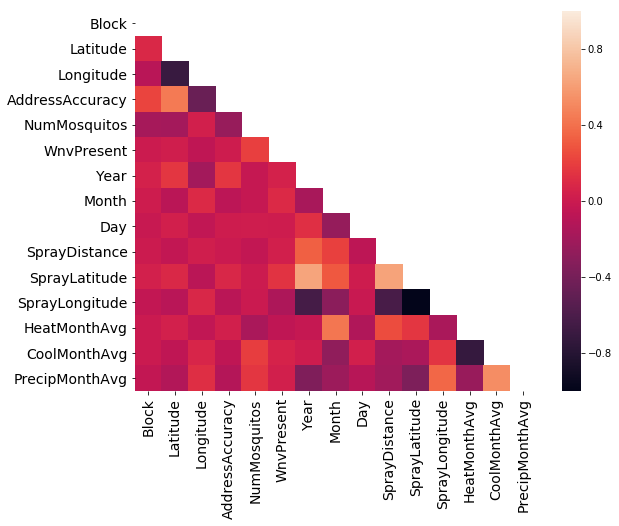

In [53]:
# correlation heatmap

mean_corr = wnv_df.corr()

fig, ax = plt.subplots(figsize=(9,7))

mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

In [54]:
wnv_df['PrecipMonthAvg'].value_counts()

0.3067    2050
0.0775     834
0.0450     774
0.0687     755
0.2475     640
0.0714     636
0.2298     578
0.1124     575
0.1131     540
0.1363     493
0.0783     486
0.1798     436
0.0355     418
0.1660     381
0.1344     374
0.0586     211
0.0968     176
0.2085      65
0.1352      59
0.0636      25
Name: PrecipMonthAvg, dtype: int64

In [55]:
spec_d = pd.get_dummies(wnv_df['Species'])
trap_d = pd.get_dummies(wnv_df['Trap'])
heat_d = pd.get_dummies(wnv_df['HeatMonthAvg'])
cool_d = pd.get_dummies(wnv_df['CoolMonthAvg'])
precip_d = pd.get_dummies(wnv_df['PrecipMonthAvg'])

y = wnv_df['WnvPresent'].values
X = pd.concat([precip_d, spec_d, trap_d, heat_d, cool_d], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [56]:
X.head()

,0.0355,0.045,0.0586,0.0636,0.0687,0.0714,0.0775,0.0783,0.0968,0.1124,...,0.0,1.0,2.0,3.0,5.0,6.0,7.0,9.0,10.0,15.0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [67]:
rfc_params={
    'n_estimators':[5,10,15,20],
    'criterion':['gini','entropy'],
    'max_depth':[1,2,3,4,None]}

rfc_gridsearch = GridSearchCV(RandomForestClassifier(), rfc_params, verbose=1, cv=5, n_jobs=4)
rfc_gridsearch.fit(X_train,y_train)

print('GridSearch score:',rfc_gridsearch.best_score_)
print('Best Parameters:', rfc_gridsearch.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done  49 tasks      | elapsed:    1.5s


GridSearch score: 0.947074501840335
Best Parameters: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 5}


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.8s finished


In [65]:
# Random Forest Model

rfc_wnv = RandomForestClassifier(max_depth=None,
                                 n_estimators=10)
rfc_wnv.fit(X_train,y_train)

score_rfc_wnv = rfc_wnv.score(X_test,y_test)

# using crossvalidation to check how accurate the model is
cv_wnv = cross_val_score(rfc_wnv, X_test, y_test, cv=5, verbose=1).mean()

print('Baseline:', baseline_accuracy)
print('Random Forrest Score:', score_rfc_wnv)
print('Cross Validation Score:', cv_wnv)

Baseline: 0.9475537787930707
Random Forrest Score: 0.9409973353635326
Cross Validation Score: 0.9318630155919797


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [66]:
y_preds = rfc_wnv.predict(X_test)

rfc_df_confusion = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
rfc_df_confusion

Predicted,0,1,All
Actual,,,
0,2453,40,2493
1,115,19,134
All,2568,59,2627


In [74]:
rfc_wnv.predict_proba(X_test)

array([0.98333333, 0.01666667])

#### Building a Keras NN

In [17]:
y_train = y_train.reshape(-1,1)

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [19]:
y_train.shape

(7879, 2)

In [20]:
model_1 = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = y_train.shape[1]

model_1.add(Dense(n_hidden,
                  input_dim= n_input,
                  activation='relu'))
model_1.add(Dropout(.2))

model_1.add(Dense(n_output,
                  activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [21]:
hist_1 = model_1.fit(X_train,y_train,
                 validation_data=(X_test,y_test),
                 epochs=5,
                 verbose=1)

Train on 7879 samples, validate on 2627 samples
Epoch 1/5
7879/7879 [==============================] - 1s 151us/step - loss: 0.2071 - acc: 0.9443 - val_loss: 0.1768 - val_acc: 0.9490
Epoch 2/5
7879/7879 [==============================] - 1s 83us/step - loss: 0.1667 - acc: 0.9471 - val_loss: 0.1737 - val_acc: 0.9490
Epoch 3/5
7879/7879 [==============================] - 1s 86us/step - loss: 0.1602 - acc: 0.9471 - val_loss: 0.1753 - val_acc: 0.9490
Epoch 4/5
7879/7879 [==============================] - 1s 86us/step - loss: 0.1562 - acc: 0.9469 - val_loss: 0.1745 - val_acc: 0.9486
Epoch 5/5
7879/7879 [==============================] - 1s 84us/step - loss: 0.1530 - acc: 0.9471 - val_loss: 0.1766 - val_acc: 0.9486


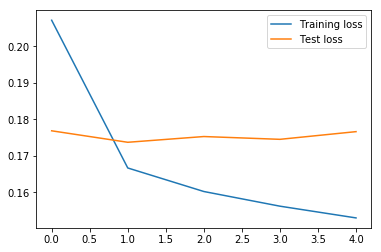

In [22]:
plt.plot(hist_1.history['loss'], label='Training loss')
plt.plot(hist_1.history['val_loss'], label='Test loss')
plt.legend()

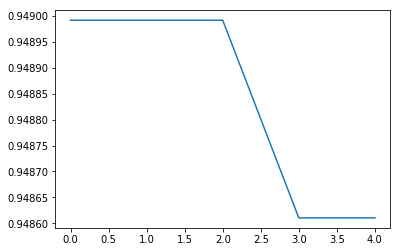

In [23]:
plt.plot(hist_1.history['val_acc'])

In [33]:
pred_list = model_1.predict_classes(X_test)

actual_list = []
for each in y_test:
    actual_list.append(np.argmax(each))
    
actual_list = pd.Series(actual_list, name='Actual')
pred_list = pd.Series(pred_list, name='Predicted')
keras_confusion = pd.crosstab(actual_list, pred_list, rownames=['Actual'], colnames=['Predicted'], margins=True)
keras_confusion

Predicted,0,1,All
Actual,,,
0,2492,1,2493
1,134,0,134
All,2626,1,2627
